<a href="https://colab.research.google.com/github/eliasingi12/DEEP_U-net_Project/blob/master/VS_code_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -L -o DRIVE.zip "https://drive.google.com/uc?export=download&id=1aSJuBxtklXelBJEt-kvG32QQYO1BIQyP"
!curl -L -o STARE.zip "https://drive.google.com/uc?export=download&id=1Iu0sKvN7oB_ARzn8ZsqNw2k7BmFZ54Aj"
!unzip DRIVE.zip
!unzip STARE.zip

In [0]:
import os  # misc operating system specific operations, e.g., reading directries.
import sys
import random

import cv2
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

from docopt import docopt

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

In [0]:
# utils.py

def read_preproc(img_paths):
    img_data = []
    for path in img_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_data.append(image)
    return img_data


def list_img_paths(dir, format):
    image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(dir):
        for img in filenames:
            if format in img and not img.startswith('.'):
                image_paths.append(os.path.join(dirpath, img))
    return image_paths


def show_images(imgs, grid_size=3):
    f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            axarr[i,j].imshow(imgs[i*grid_size+j])
    plt.show()


def img2bin(img):
    img_new = img.copy() # Make copy instead of changing origianl list
    rows, cols = img_new.shape
    for row in range(rows):
        for col in range(cols):
            if img_new[row][col]*255 > 215:
                img_new[row][col] = 1
            else:
                img_new[row][col] = 0
    return img_new.astype(int)

def iou(pred,target):
    intersection = pred*target
    notTrue = 1 - target
    union = target + (notTrue * pred)
    return np.sum(intersection)/np.sum(union)


def avg_iou(preds,targets):

    assert len(preds) == len(targets)
    
    bin_targets = []
    for img in targets:
        bin_targets.append(img2bin(img))

    bin_preds = []
    for img in preds:
        bin_preds.append(img2bin(img))

    pred_targets = [(bin_preds[i], bin_targets[i]) for i in range(len(bin_preds))]

    train_iou = []
    for pred, target in pred_targets:
        train_iou.append(iou(pred,target))

    return sum(train_iou)/len(preds)
  
  
def reshape_normalize(arr_to_reshape):
    arr_to_reshape = arr_to_reshape.reshape(arr_to_reshape.shape[0], 512, 512, 1)
    arr_to_reshape = arr_to_reshape.astype('float32')
    arr_to_reshape /= 255
    return arr_to_reshape
  

In [0]:
def unet(height,width,n_ch):
    inputs = Input((height,width,n_ch))
    
    # First set of layers
    down1 = Conv2D(64, (3,3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3,3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2,2))(down1)

    # Second set of layers
    down2 = Conv2D(128, (3,3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3,3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2,2))(down2)

    # Third set of layers
    down3 = Conv2D(256, (3,3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3,3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2,2))(down3)

    # Fourth set of layers
    down4 = Conv2D(512, (3,3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3,3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2,2))(down4)

    # Fifth set of layers
    mid = Conv2D(1024, (3,3), padding='same')(down4_pool)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)
    mid = Conv2D(1024, (3,3), padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)

    # First up layers
    up4 = UpSampling2D((2,2))(mid)
    up4 = concatenate([down4,up4], axis=3)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    # Second up layers
    up3 = UpSampling2D((2,2))(up4)
    up3 = concatenate([down3,up3], axis=3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    # Third up layers
    up2 = UpSampling2D((2,2))(up3)
    up2 = concatenate([down2,up2], axis=3)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    # Fourth up layers
    up1 = UpSampling2D((2,2))(up2)
    up1 = concatenate([down1,up1], axis=3)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    # Output layer
    out = Conv2D(1, (1,1), padding='same')(up1)
    out = Activation('sigmoid')(out)

    model = Model(inputs=inputs, outputs=out)

    model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [41]:
random_seed = 42
random.seed(random_seed)
#image_paths = []
#target_paths = []
#test_image_paths = []
#test_target_paths = []

full_paths = {}
full_paths["training_imgs"] = "DRIVE/training/images"
full_paths["targets"] = "DRIVE/training/1st_manual_tif"
full_paths["testing_imgs"] = "DRIVE/test/images/"
full_paths["testing_targets"] = "DRIVE/test/1st_manual_tif"
full_paths["STARE_imgs"] = "STARE/stare_images_tif"
full_paths["STARE_masks_vk"] = "STARE/labels_vk_tif"

# Training set
image_paths = list_img_paths(full_paths["training_imgs"], '.tif')
image_paths.sort()
target_paths = list_img_paths(full_paths["targets"], '.tif')
target_paths.sort()

# Testing set
test_image_paths = list_img_paths(full_paths["testing_imgs"], '.tif')
test_image_paths.sort()
test_target_paths = list_img_paths(full_paths["testing_targets"], '.tif')
test_target_paths.sort()

augment = True
no_imgs = 4

if augment:
    print("Augmenting...")

    # Change DRIVE set to 90:10 train:test instead of 50:50 and add STARE dataset
    image_paths.extend(test_image_paths[:-no_imgs])
    test_image_paths = test_image_paths[-no_imgs:]

    target_paths.extend(test_target_paths[:-no_imgs])
    test_target_paths = test_target_paths[-no_imgs:]

    #STARE_imgs = list_img_paths(full_paths["STARE_imgs"], '.tif')
    #STARE_imgs.sort()
    #STARE_targs = list_img_paths(full_paths["STARE_masks_vk"], '.tif')
    #STARE_targs.sort()

    #image_paths.extend(STARE_imgs[:-2])
    #test_image_paths.extend(STARE_imgs[-2:])

    #target_paths.extend(STARE_targs[:-2])
    #test_target_paths.extend(STARE_targs[-2:])


train_input = read_preproc(image_paths)
train_target = read_preproc(target_paths)
test_input = read_preproc(test_image_paths)
test_target = read_preproc(test_target_paths)

train_input = np.array(train_input)
train_target = np.array(train_target)
test_input = np.array(test_input)
test_target = np.array(test_target)

train_input = reshape_normalize(train_input)
train_target = reshape_normalize(train_target)
test_input = reshape_normalize(test_input)
test_target = reshape_normalize(test_target)

Augmenting...


In [42]:
h, w, ch = train_input[0].shape
EPOCHS=10

model = unet(h,w,ch)
model.summary()

model.fit(train_input, train_target, epochs=EPOCHS, batch_size=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 512, 512, 64) 640         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_199 (BatchN (None, 512, 512, 64) 256         conv2d_208[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 512, 512, 64) 0           batch_normalization_199[0][0]    
__________________________________________________________________________________________________
conv2d_209

In [0]:
# training prediction
train_pred = []
for i in range(40-no_imgs):
    train_input_fix = np.expand_dims(train_input[i], axis=0)
    train_pred.append(model.predict(train_input_fix))

train_pred = np.array(train_pred)
#train_pred = train_pred.reshape(train_pred.shape[0], 512, 512) 
#plt.imshow(train_pred[52], interpolation='nearest')
#plt.show()


# testing prediction
test_pred = model.predict(test_input)

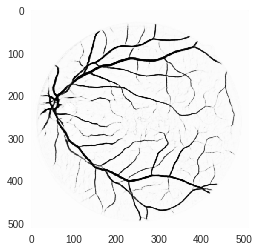

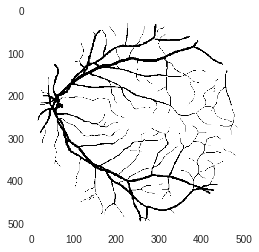

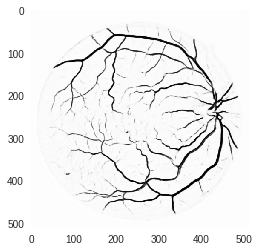

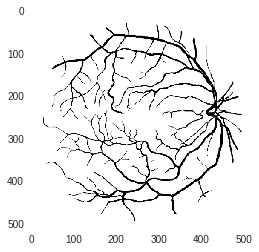

In [44]:
### Display Images ###
train_target = train_target.reshape(train_target.shape[0], 512, 512)
test_target = test_target.reshape(test_target.shape[0], 512, 512)
train_pred = train_pred.reshape(train_pred.shape[0], 512, 512) 
test_pred = test_pred.reshape(test_pred.shape[0], 512, 512) 

plt.imshow(train_pred[0], interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(train_target[0], interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(test_pred[0], interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(test_target[0], interpolation='nearest')
plt.grid(False)
plt.show()
### ###

In [45]:
print("train: ")
print(avg_iou(train_pred, train_target))

print("test: ")
print(avg_iou(test_pred, test_target))


train: 
0.5027601056727824
test: 
0.4950236084232059


image: 0...


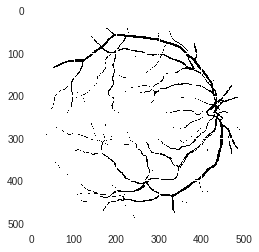

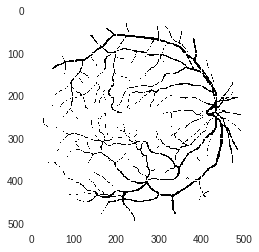

image: 1...


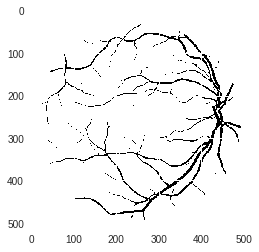

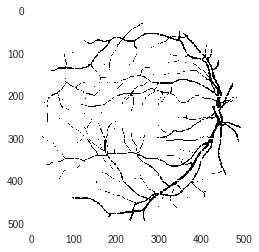

image: 2...


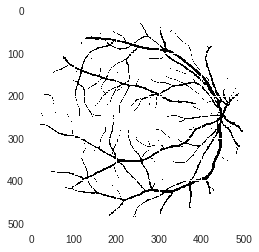

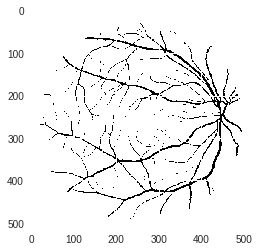

image: 3...


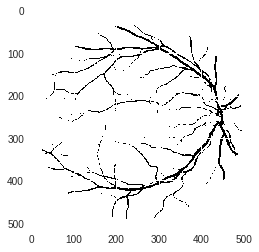

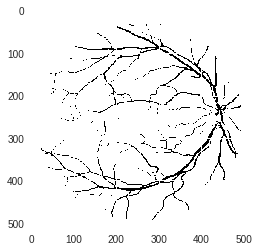

image: 4...


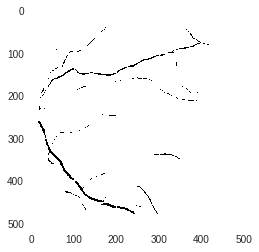

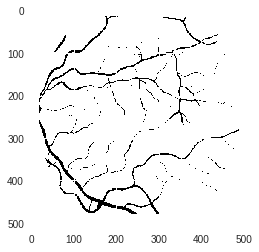

image: 5...


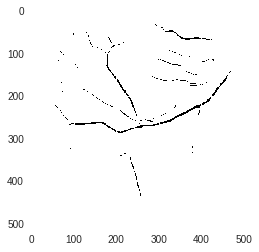

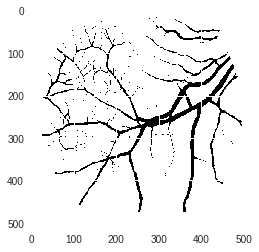

train_avg: 
0.07915435080455967
test_avg: 
0.4862438391045875


In [0]:
# check iou of test and train data
#train_sum = 0
test_sum = 0
for i in range(len(test_pred)):
    print("image: " + str(i) + "...")
    train_iou = iou(img2bin(train_pred[i]), img2bin(train_target[i]))
    test_iou = iou(img2bin(test_pred[i]), img2bin(test_target[i]))
    plt.imshow(img2bin(test_pred[i]), interpolation='nearest')
    plt.show()
    plt.imshow(img2bin(test_target[i]), interpolation='nearest')
    plt.show()
    train_sum += train_iou
    test_sum += test_iou
    
print("train_avg: ")
print(train_sum/len(train_pred))

print("test_avg: ")
print(test_sum/len(test_pred))

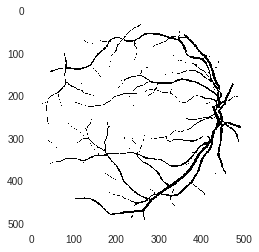

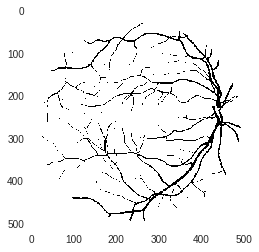

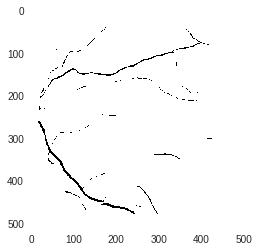

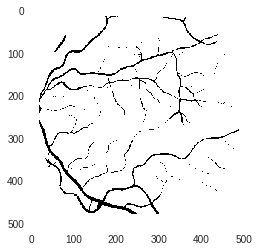

In [0]:
#plt.imshow(img2bin(train_pred[0]), interpolation='nearest')
#plt.show()

#plt.imshow(img2bin(train_target[0]), interpolation='nearest')
#plt.show()

plt.imshow(img2bin(test_pred[1]), interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(img2bin(test_target[1]), interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(img2bin(test_pred[4]), interpolation='nearest')
plt.grid(False)
plt.show()

plt.imshow(img2bin(test_target[4]), interpolation='nearest')
plt.grid(False)
plt.show()